In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import seaborn as sns

In [9]:
tickers = ['MSTR','BTC-USD']
df = yf.download(tickers,period = "30d", interval = "5m")['Close']
df.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [10]:
log_prices = np.log(df)
log_prices = log_prices.reset_index()

In [11]:
log_return = np.log(df/df.shift()).dropna()
log_return = log_return.reset_index()

In [12]:
df=df.reset_index()

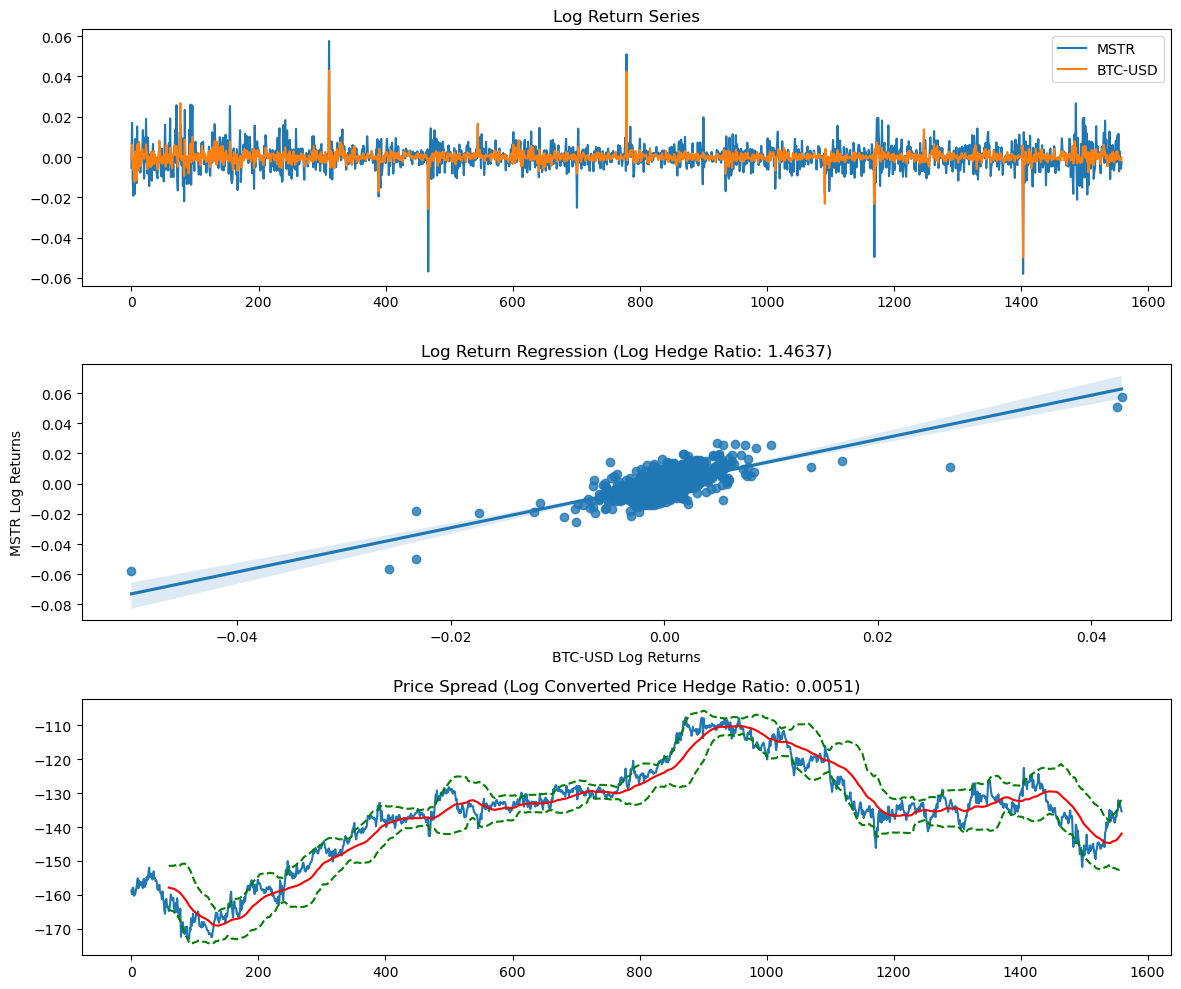

In [19]:
X = log_return['BTC-USD'].values.reshape(-1, 1)
y = log_return['MSTR'].values
model = sm.OLS(y, sm.add_constant(X)).fit()
log_hedge_ratio = model.params[1]

price_hedge_ratio = log_hedge_ratio * (df['MSTR'].mean() / df['BTC-USD'].mean())

spread = df['MSTR'] - price_hedge_ratio * df['BTC-USD']


plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(log_return.index, log_return['MSTR'], label='MSTR')
plt.plot(log_return.index, log_return['BTC-USD'], label='BTC-USD')
plt.title('Log Return Series')
plt.legend()


plt.subplot(3, 1, 2)
sns.regplot(x=log_return['BTC-USD'], y=log_return['MSTR'])
plt.title(f'Log Return Regression (Log Hedge Ratio: {log_hedge_ratio:.4f})')
plt.xlabel('BTC-USD Log Returns')
plt.ylabel('MSTR Log Returns')

z_score = (spread - spread.mean()) / spread.std()

plt.subplot(3, 1, 3)
plt.plot(df.index, spread)
plt.title(f'Price Spread (Log Converted Price Hedge Ratio: {price_hedge_ratio:.4f})')
plt.plot(df.index, spread.rolling(window=60).mean(), color='r', linestyle='-')
plt.plot(df.index, spread.rolling(window=60).mean() + 2*spread.rolling(window=60).std(), color='g', linestyle='--')
plt.plot(df.index, spread.rolling(window=60).mean() - 2*spread.rolling(window=60).std(), color='g', linestyle='--')

plt.tight_layout()
plt.show()

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_47109/3571565334.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  direct_hedge_ratio = price_model.params[1]
/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_47109/3571565334.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  direct_alpha = price_model.params[0]


Hedge ratio:0.010026959259819942, alpha: -549.3796865396248


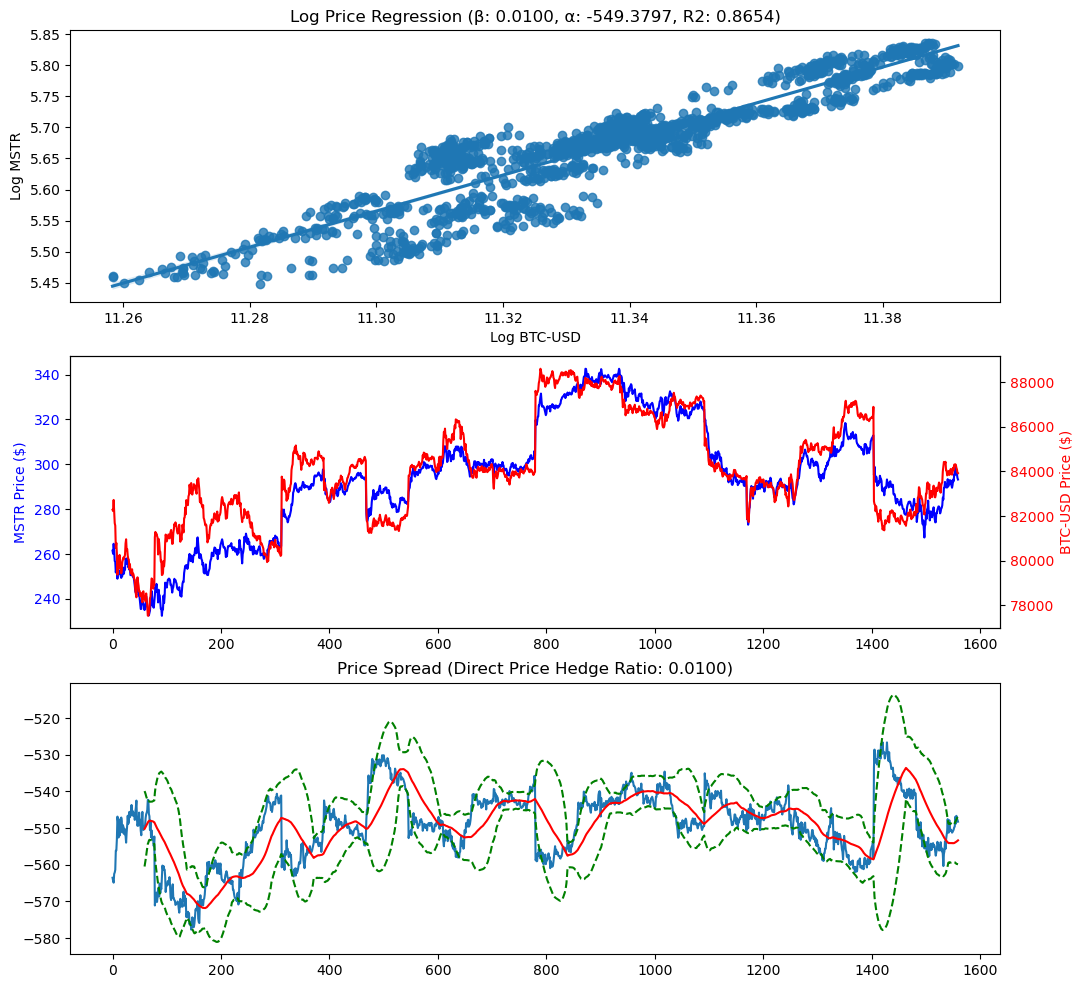

In [25]:
price_model = sm.OLS(df['MSTR'], sm.add_constant(df['BTC-USD'])).fit()
direct_hedge_ratio = price_model.params[1]
direct_alpha = price_model.params[0]
r_squared = price_model.rsquared
adj_r_squared = price_model.rsquared_adj

print(f'Hedge ratio:{direct_hedge_ratio}, alpha: {direct_alpha}')

spread = df['MSTR'] - direct_hedge_ratio * df['BTC-USD']


plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
sns.regplot(x=log_prices['BTC-USD'], y=log_prices['MSTR'])
plt.title(f'Log Price Regression (β: {direct_hedge_ratio:.4f}, α: {direct_alpha:.4f}, R2: {r_squared:.4f})')
plt.xlabel('Log BTC-USD')
plt.ylabel('Log MSTR')

plt.subplot(3, 1, 2)
fig = plt.gca()
mstr_line = fig.plot(df.index, df['MSTR'], 'b-', label='MSTR')
plt.ylabel('MSTR Price ($)', color='b')
plt.tick_params(axis='y', labelcolor='b')

# Create second y-axis
ax2 = fig.twinx()
btc_line = ax2.plot(df.index, df['BTC-USD'], 'r-', label='BTC-USD')
ax2.set_ylabel('BTC-USD Price ($)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.subplot(3, 1, 3)
plt.plot(df.index, spread)
plt.title(f'Price Spread (Direct Price Hedge Ratio: {direct_hedge_ratio:.4f})')
plt.plot(df.index, spread.rolling(window=60).mean(), color='r', linestyle='-')
plt.plot(df.index, spread.rolling(window=60).mean() + 2*spread.rolling(window=60).std(), color='g', linestyle='--')
plt.plot(df.index, spread.rolling(window=60).mean() - 2*spread.rolling(window=60).std(), color='g', linestyle='--')
plt.show()

In [31]:
def Calculate_sharpe(df,portfolio_returns):
    time_diff = pd.Series(df['Datetime'].diff().dt.total_seconds())
    avg_time_diff = time_diff.mean()

    seconds_in_year = 365.25 * 24 * 60 * 60
    periods_per_year = seconds_in_year / avg_time_diff if avg_time_diff > 0 else 0
    
    annualization_factor = np.sqrt(periods_per_year)

    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * annualization_factor if portfolio_returns.std() != 0 else 0
    return sharpe_ratio

In [56]:
def alpha_capture_strategy(df, asset_col='SPY', hedge_col='VXX', is_plot=False,
                          rolling_window=60, update_period=30,
                          asset_1_fee=0.001, asset_2_fee=0.0005,
                          asset_1_slippage=0.0001, asset_2_slippage=0.0005):
    
    asset_returns = df[asset_col].pct_change().fillna(0)
    hedge_returns = df[hedge_col].pct_change().fillna(0)
    
    asset_positions = pd.Series(0.0, index=df.index)
    hedge_positions = pd.Series(0.0, index=df.index)
    
    observed_alpha = pd.Series(0.0, index=df.index)
    observed_hedge_ratio = pd.Series(0.0, index=df.index)
    
    for i in range(rolling_window, len(df), update_period):
        window_end = i
        window_start = max(0, window_end - rolling_window)
        
        window_df = df.iloc[window_start:window_end]
        X = window_df[hedge_col].values.reshape(-1, 1)
        y = window_df[asset_col].values
        
        X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
        
        try:
            coeffs, residuals, rank, s = np.linalg.lstsq(X_with_const, y, rcond=None)
            current_alpha = float(coeffs[0])
            current_hedge_ratio = float(coeffs[1])
        except:
            if i > rolling_window:
                prev_idx = max(0, i - update_period)
                current_alpha = float(observed_alpha.iloc[prev_idx]) if observed_alpha.iloc[prev_idx] != 0 else 0.0
                current_hedge_ratio = float(observed_hedge_ratio.iloc[prev_idx]) if observed_hedge_ratio.iloc[prev_idx] != 0 else 0.0
            else:
                current_alpha = 0.0
                current_hedge_ratio = 0.0
        
        asset_direction = -1.0 if current_alpha < 0 else 1.0
        hedge_direction = -asset_direction
        
        update_end = min(i + update_period, len(df))
        asset_positions.iloc[i:update_end] = asset_direction
        hedge_positions.iloc[i:update_end] = hedge_direction * current_hedge_ratio
        
        observed_alpha.iloc[i:update_end] = current_alpha
        observed_hedge_ratio.iloc[i:update_end] = current_hedge_ratio
    
    asset_position_changes = asset_positions.diff().fillna(0)
    hedge_position_changes = hedge_positions.diff().fillna(0)
    
    asset_trades = asset_position_changes != 0
    hedge_trades = hedge_position_changes != 0
    
    asset_transaction_costs = pd.Series(0.0, index=df.index)
    hedge_transaction_costs = pd.Series(0.0, index=df.index)
    
    asset_transaction_costs[asset_trades] = asset_1_fee + asset_1_slippage
    hedge_transaction_costs[hedge_trades] = asset_2_fee + asset_2_slippage
    
    asset_returns_after_costs = asset_returns.copy()
    hedge_returns_after_costs = hedge_returns.copy()
    
    asset_returns_after_costs[asset_trades] -= asset_transaction_costs[asset_trades] * np.sign(asset_position_changes[asset_trades])
    hedge_returns_after_costs[hedge_trades] -= hedge_transaction_costs[hedge_trades] * np.sign(hedge_position_changes[hedge_trades])
    
    portfolio_returns = (asset_positions.shift(1) * asset_returns_after_costs + 
                         hedge_positions.shift(1) * hedge_returns_after_costs)
    portfolio_returns = portfolio_returns.fillna(0)
    
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / (1 + rolling_max)
    max_drawdown = drawdown.min()

    total_return = cumulative_returns.iloc[-1]
    
    sharpe_ratio = Calculate_sharpe(df,portfolio_returns)
    
    if is_plot:
        rolling_alphas = pd.Series(0.0, index=df.index)
        rolling_hedge_ratios = pd.Series(0.0, index=df.index)
        
        for i in range(rolling_window, len(df)):
            window_start = max(0, i - rolling_window)
            window_df = df.iloc[window_start:i]
            X = window_df[hedge_col].values.reshape(-1, 1)
            y = window_df[asset_col].values
            
            X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
            try:
                coeffs, residuals, rank, s = np.linalg.lstsq(X_with_const, y, rcond=None)
                rolling_alphas.iloc[i] = coeffs[0]
                rolling_hedge_ratios.iloc[i] = coeffs[1]
            except:
                if i > 0:
                    rolling_alphas.iloc[i] = rolling_alphas.iloc[i-1] if rolling_alphas.iloc[i-1] != 0 else 0
                    rolling_hedge_ratios.iloc[i] = rolling_hedge_ratios.iloc[i-1] if rolling_hedge_ratios.iloc[i-1] != 0 else 0
        
        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 1, 1)
        plt.plot(df.index[rolling_window:], rolling_alphas[rolling_window:], 'b-', label='Rolling Alpha')
        plt.plot(df.index[rolling_window:], observed_alpha[rolling_window:], 'r--', label='Strategy Alpha (with lag)')
        plt.title(f'Alpha Over Time (Rolling Window: {rolling_window}, Update Period: {update_period})')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(df.index[rolling_window:], rolling_hedge_ratios[rolling_window:], 'g-', label='Rolling Hedge Ratio')
        plt.plot(df.index[rolling_window:], observed_hedge_ratio[rolling_window:], 'm--', label='Strategy Hedge Ratio (with lag)')
        plt.title('Hedge Ratio Over Time')
        plt.legend()

        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 1, 1)
        plt.plot(df.index[rolling_window:], cumulative_returns[rolling_window:] * 100, 'b-')
        plt.title(f'Strategy Cumulative Returns (%)') 
        plt.grid(True)
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.ylabel('Return (%)')
        
        plt.subplot(2, 1, 2)
        plt.plot(df.index[rolling_window:], asset_positions[rolling_window:], 'b-', label=f'{asset_col} Position')
        plt.plot(df.index[rolling_window:], hedge_positions[rolling_window:], 'r-', label=f'{hedge_col} Position')
        plt.title('Position Sizes Over Time')
        plt.legend()

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 1, 1)
        plt.hist(portfolio_returns*100, bins=50)
        plt.title(f'Return Distribution (%)')
        plt.grid(True)
        
        # Fixed plot for transaction costs
        plt.subplot(2, 1, 2)
        trade_dates_asset = df.index[asset_trades]
        trade_dates_hedge = df.index[hedge_trades]
        
        if len(trade_dates_asset) > 0:
            plt.plot(trade_dates_asset, asset_transaction_costs[asset_trades] * 100, 'b.', label=f'{asset_col} Costs')
        if len(trade_dates_hedge) > 0:
            plt.plot(trade_dates_hedge, hedge_transaction_costs[hedge_trades] * 100, 'r.', label=f'{hedge_col} Costs')
        
        plt.title('Transaction Costs (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 6))
        plt.plot(df.index[rolling_window:], drawdown[rolling_window:] * 100, 'r-')
        plt.title(f'Drawdown Over Time (%)') 
        plt.grid(True)
        plt.ylabel('Drawdown (%)')
        plt.tight_layout()
        plt.show()
              
        total_asset_costs = (asset_transaction_costs * abs(asset_position_changes)).sum()
        total_hedge_costs = (hedge_transaction_costs * abs(hedge_position_changes)).sum()
        total_costs = total_asset_costs + total_hedge_costs
        
        turnover_asset = abs(asset_position_changes).sum()
        turnover_hedge = abs(hedge_position_changes).sum()
        
        print(f"Strategy Parameters:")
        print(f"Rolling Window: {rolling_window} periods")
        print(f"Update Period: {update_period} periods")
        print(f"Asset 1 Fee: {asset_1_fee:.4%}, Slippage: {asset_1_slippage:.4%}")
        print(f"Asset 2 Fee: {asset_2_fee:.4%}, Slippage: {asset_2_slippage:.4%}")
        print(f"\nPerformance Metrics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Maximum Drawdown: {max_drawdown:.2%}")
        print(f"\nTransaction Costs:")
        print(f"Total Asset 1 Costs: {total_asset_costs:.2%}")
        print(f"Total Asset 2 Costs: {total_hedge_costs:.2%}")
        print(f"Total Costs: {total_costs:.2%}")
        print(f"Turnover - Asset 1: {turnover_asset:.2f}, Asset 2: {turnover_hedge:.2f}")
        
        alpha_mean = observed_alpha[observed_alpha != 0].mean() if len(observed_alpha[observed_alpha != 0]) > 0 else 0
        alpha_std = observed_alpha[observed_alpha != 0].std() if len(observed_alpha[observed_alpha != 0]) > 0 else 0
        ratio_mean = observed_hedge_ratio[observed_hedge_ratio != 0].mean() if len(observed_hedge_ratio[observed_hedge_ratio != 0]) > 0 else 0
        ratio_std = observed_hedge_ratio[observed_hedge_ratio != 0].std() if len(observed_hedge_ratio[observed_hedge_ratio != 0]) > 0 else 0
        
        print(f"\nParameter Statistics:")
        print(f"Alpha - Mean: {alpha_mean:.2f}, Std: {alpha_std:.2f}, CV: {alpha_std/abs(alpha_mean) if alpha_mean != 0 else float('inf'):.2f}")
        print(f"Hedge Ratio - Mean: {ratio_mean:.6f}, Std: {ratio_std:.6f}, CV: {ratio_std/abs(ratio_mean) if ratio_mean != 0 else float('inf'):.2f}")
    
    return {
        'portfolio_returns': portfolio_returns,
        'cumulative_returns': cumulative_returns,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'observed_alpha': observed_alpha,
        'observed_hedge_ratio': observed_hedge_ratio,
        'asset_positions': asset_positions,
        'hedge_positions': hedge_positions,
        'drawdown': drawdown,
        'asset_trades': asset_trades.sum(),
        'hedge_trades': hedge_trades.sum(),
        'asset_costs': (asset_transaction_costs * abs(asset_position_changes)).sum(),
        'hedge_costs': (hedge_transaction_costs * abs(hedge_position_changes)).sum(),
        'total_costs': (asset_transaction_costs * abs(asset_position_changes)).sum() + 
                      (hedge_transaction_costs * abs(hedge_position_changes)).sum()
    }

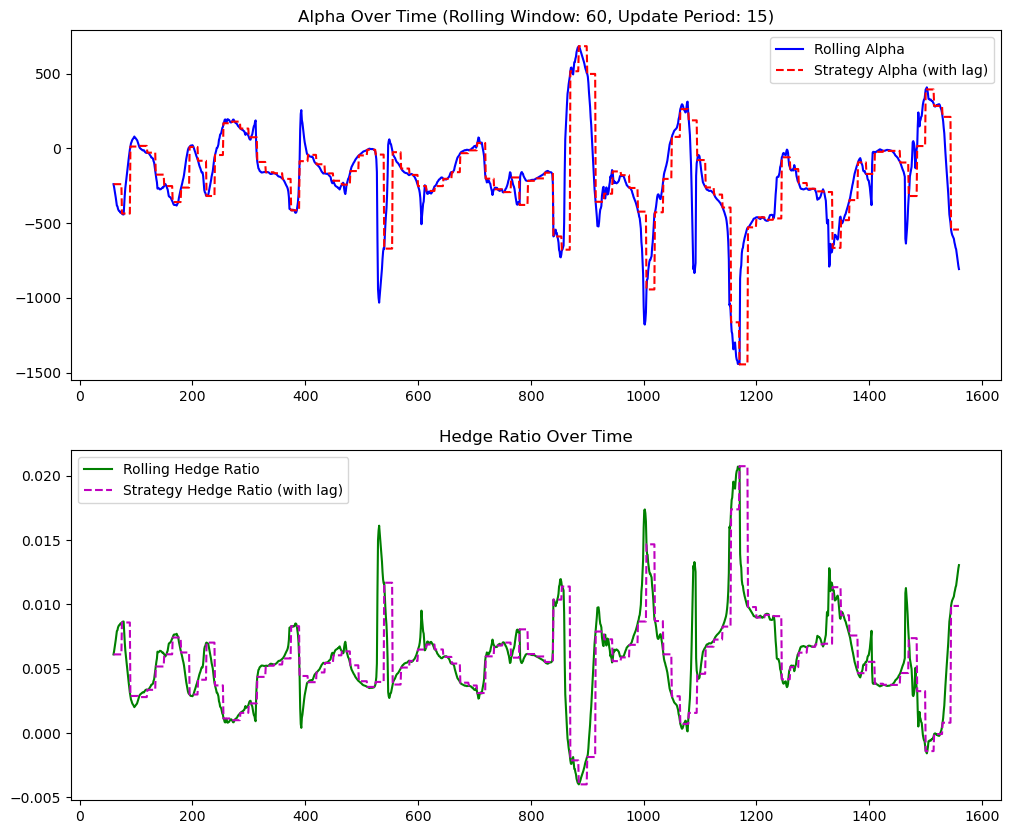

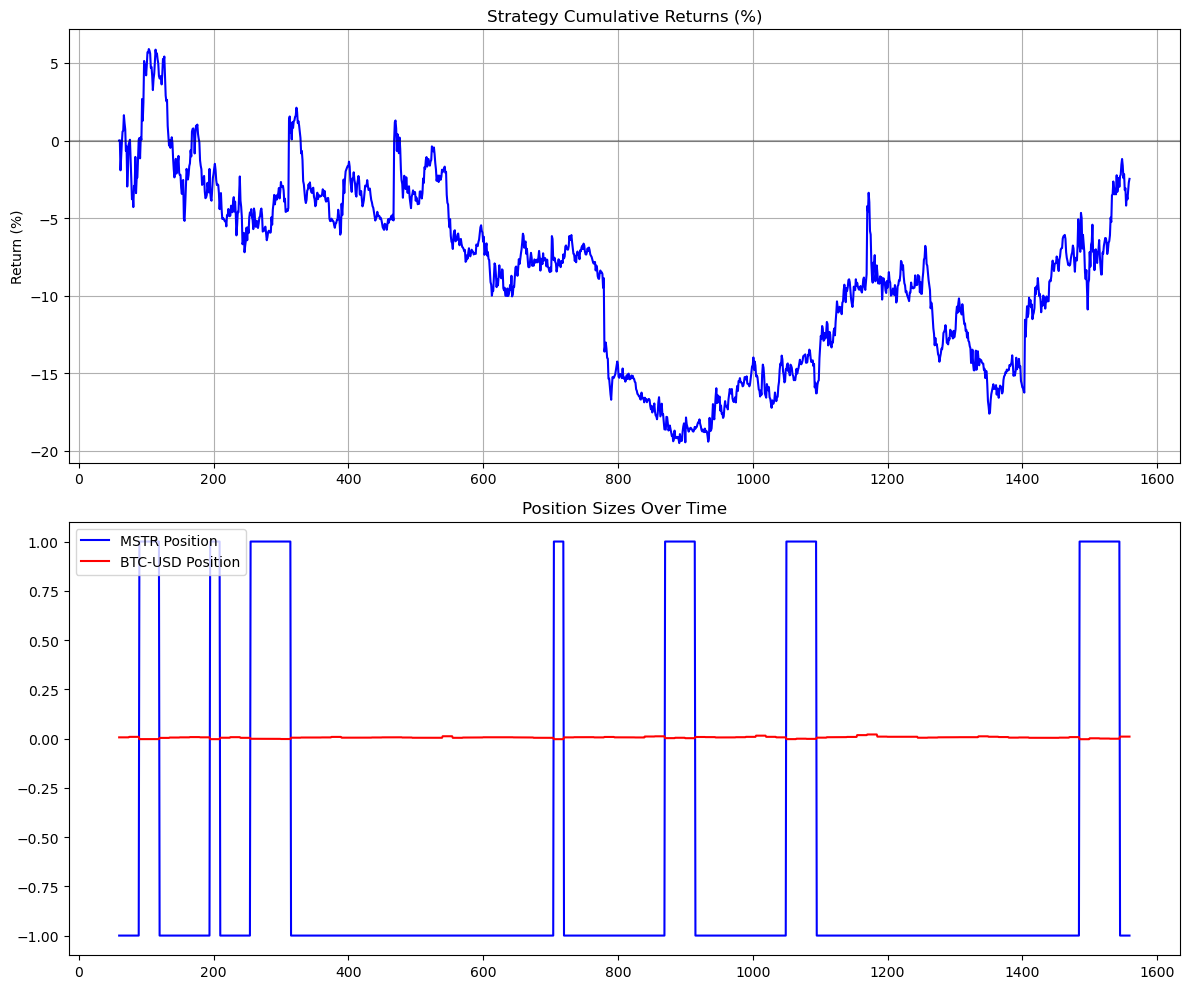

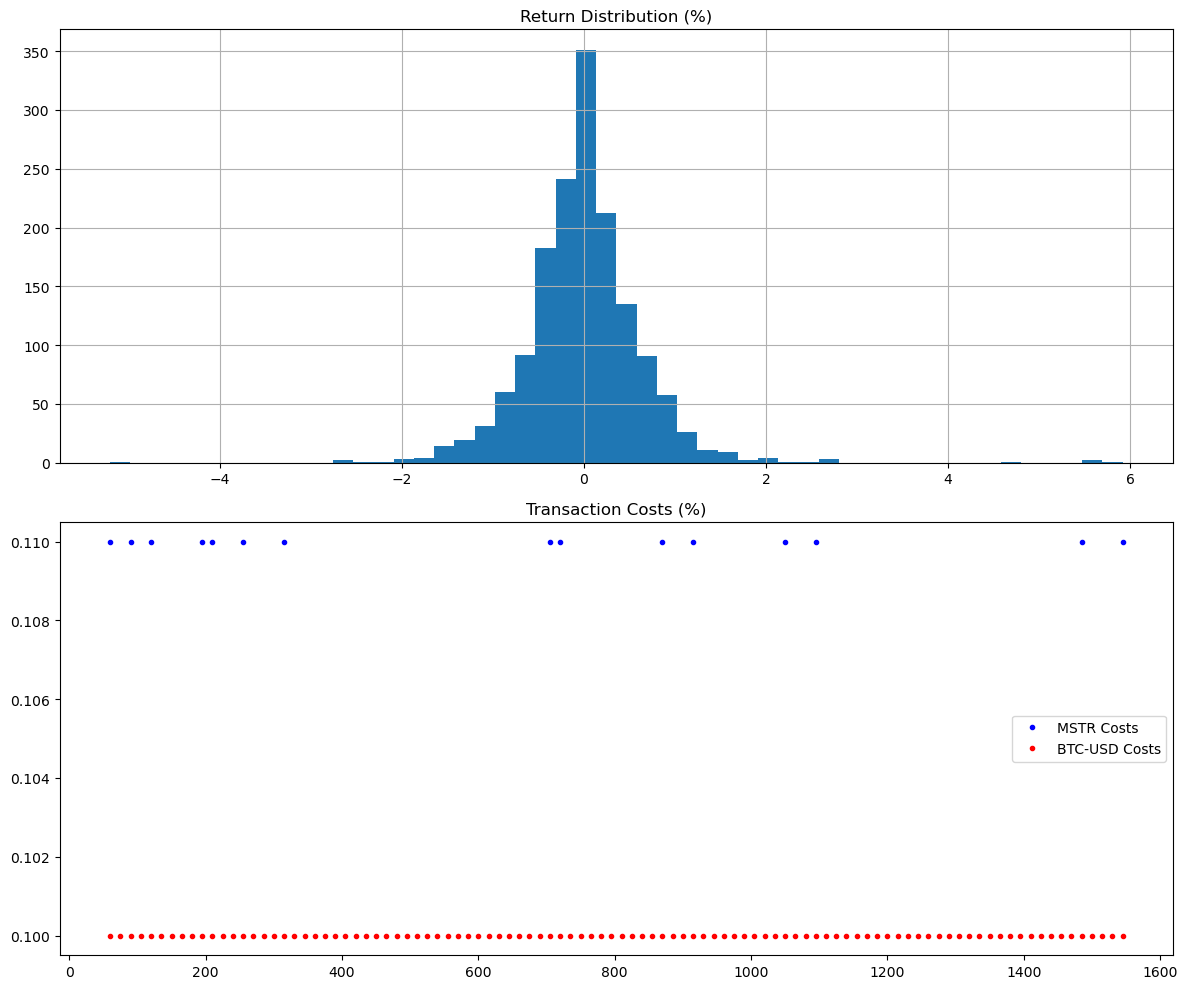

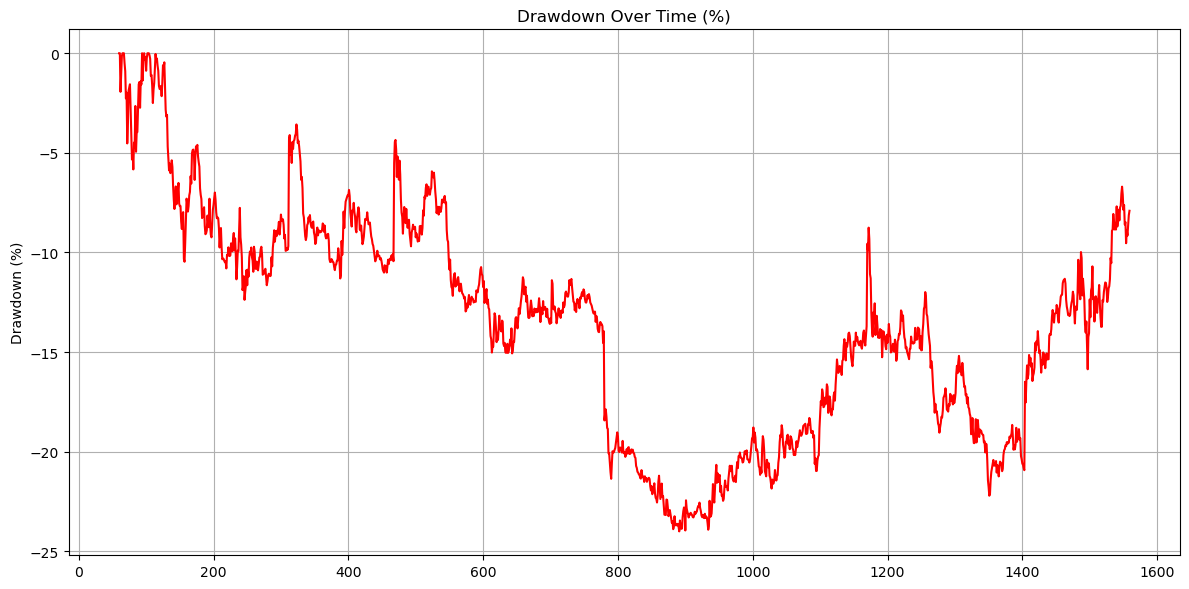

Strategy Parameters:
Rolling Window: 60 periods
Update Period: 15 periods
Asset 1 Fee: 0.1000%, Slippage: 0.0100%
Asset 2 Fee: 0.0500%, Slippage: 0.0500%

Performance Metrics:
Total Return: -2.47%
Annualized Sharpe Ratio: 0.13
Maximum Drawdown: -24.00%

Transaction Costs:
Total Asset 1 Costs: 3.19%
Total Asset 2 Costs: 0.03%
Total Costs: 3.22%
Turnover - Asset 1: 29.00, Asset 2: 0.27

Parameter Statistics:
Alpha - Mean: -188.11, Std: 299.93, CV: 1.59
Hedge Ratio - Mean: 0.005725, Std: 0.003555, CV: 0.62


In [60]:
result = alpha_capture_strategy(df, asset_col='MSTR', hedge_col='BTC-USD', is_plot=True, 
                          rolling_window=60, update_period=15)